In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sys
sys.path.append('../pp_1st')
sys.path.append('../pp_2nd')
import pp1st_pipeline
import pp1st_func
import pp2nd_func
from sklearn.experimental import enable_iterative_imputer  
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from xgboost.sklearn import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
import lightgbm as lgbm
from tqdm import tqdm
# from sklearn.svm import SVC
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 50)

In [2]:
import importlib
importlib.reload(pp2nd_func)

<module 'pp2nd_func' from '../pp_2nd/pp2nd_func.py'>

In [3]:
data = pd.read_csv('../raw/PJT002_train.csv', )
data_val = pd.read_csv('../raw/PJT002_validation.csv' )
data_test = pd.read_csv('../raw/PJT002_test.csv')

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (8,172,173,174,175,176,177,178,179) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
data = pp2nd_func.replace(data)
data = pp2nd_func.label_encoding(data)

In [5]:
data['mlt_us_yn'] = data['mlt_us_yn'].apply(lambda x : 1 if x=='Y' else 0)

- dt of _athrztn

In [6]:
data = pp2nd_func.dt_of_athrztn(data)

In [7]:
data['dt_of_athrztn'] = data['dt_of_athrztn'].astype(int)
data['dt_of_athrztn'].replace(0, np.nan , inplace=True)

In [8]:
data['dt_of_athrztn_enc'] = np.nan
data.loc[data['dt_of_athrztn'] < 1950, 'dt_of_athrztn_enc'] = 0
data.loc[(data['dt_of_athrztn'] > 1950) & (data['dt_of_athrztn'] <= 1970), 'dt_of_athrztn_enc'] = 1
data.loc[(data['dt_of_athrztn'] > 1970) & (data['dt_of_athrztn'] <= 1990), 'dt_of_athrztn_enc'] = 2
data.loc[(data['dt_of_athrztn'] > 1990) & (data['dt_of_athrztn'] <= 2010), 'dt_of_athrztn_enc'] = 3
data.loc[data['dt_of_athrztn'] > 2010, 'dt_of_athrztn_enc'] = 4

In [23]:
dt_of_ath_imputer = IterativeImputer( max_iter=30 )

In [45]:
data['dt_of_athrztn_enc'] = data['dt_of_athrztn_enc'].astype('category')

In [234]:
# data['dt_of_athrztn_enc'].replace(1950, np.nan , inplace=True)

In [25]:
dt_of_ath_res = dt_of_ath_imputer.fit_transform(data[['dt_of_athrztn_enc','bldng_cnt','bldng_ar','jmk_enc','gas_mean','hm_cnt','tbc_rtl_str_dstnc']])
dt_of_ath_df = pd.DataFrame(dt_of_ath_res , columns = ['dt_of_athrztn_enc','bldng_cnt','bldng_ar','jmk_enc','gas_mean','hm_cnt','tbc_rtl_str_dstnc'])
data = pd.concat([data.drop(columns = 'dt_of_athrztn_enc'), dt_of_ath_df['dt_of_athrztn_enc']] ,axis=1)

In [26]:
data['dt_of_athrztn_enc'] =  data['dt_of_athrztn_enc'].apply(lambda x : np.round(x))

/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


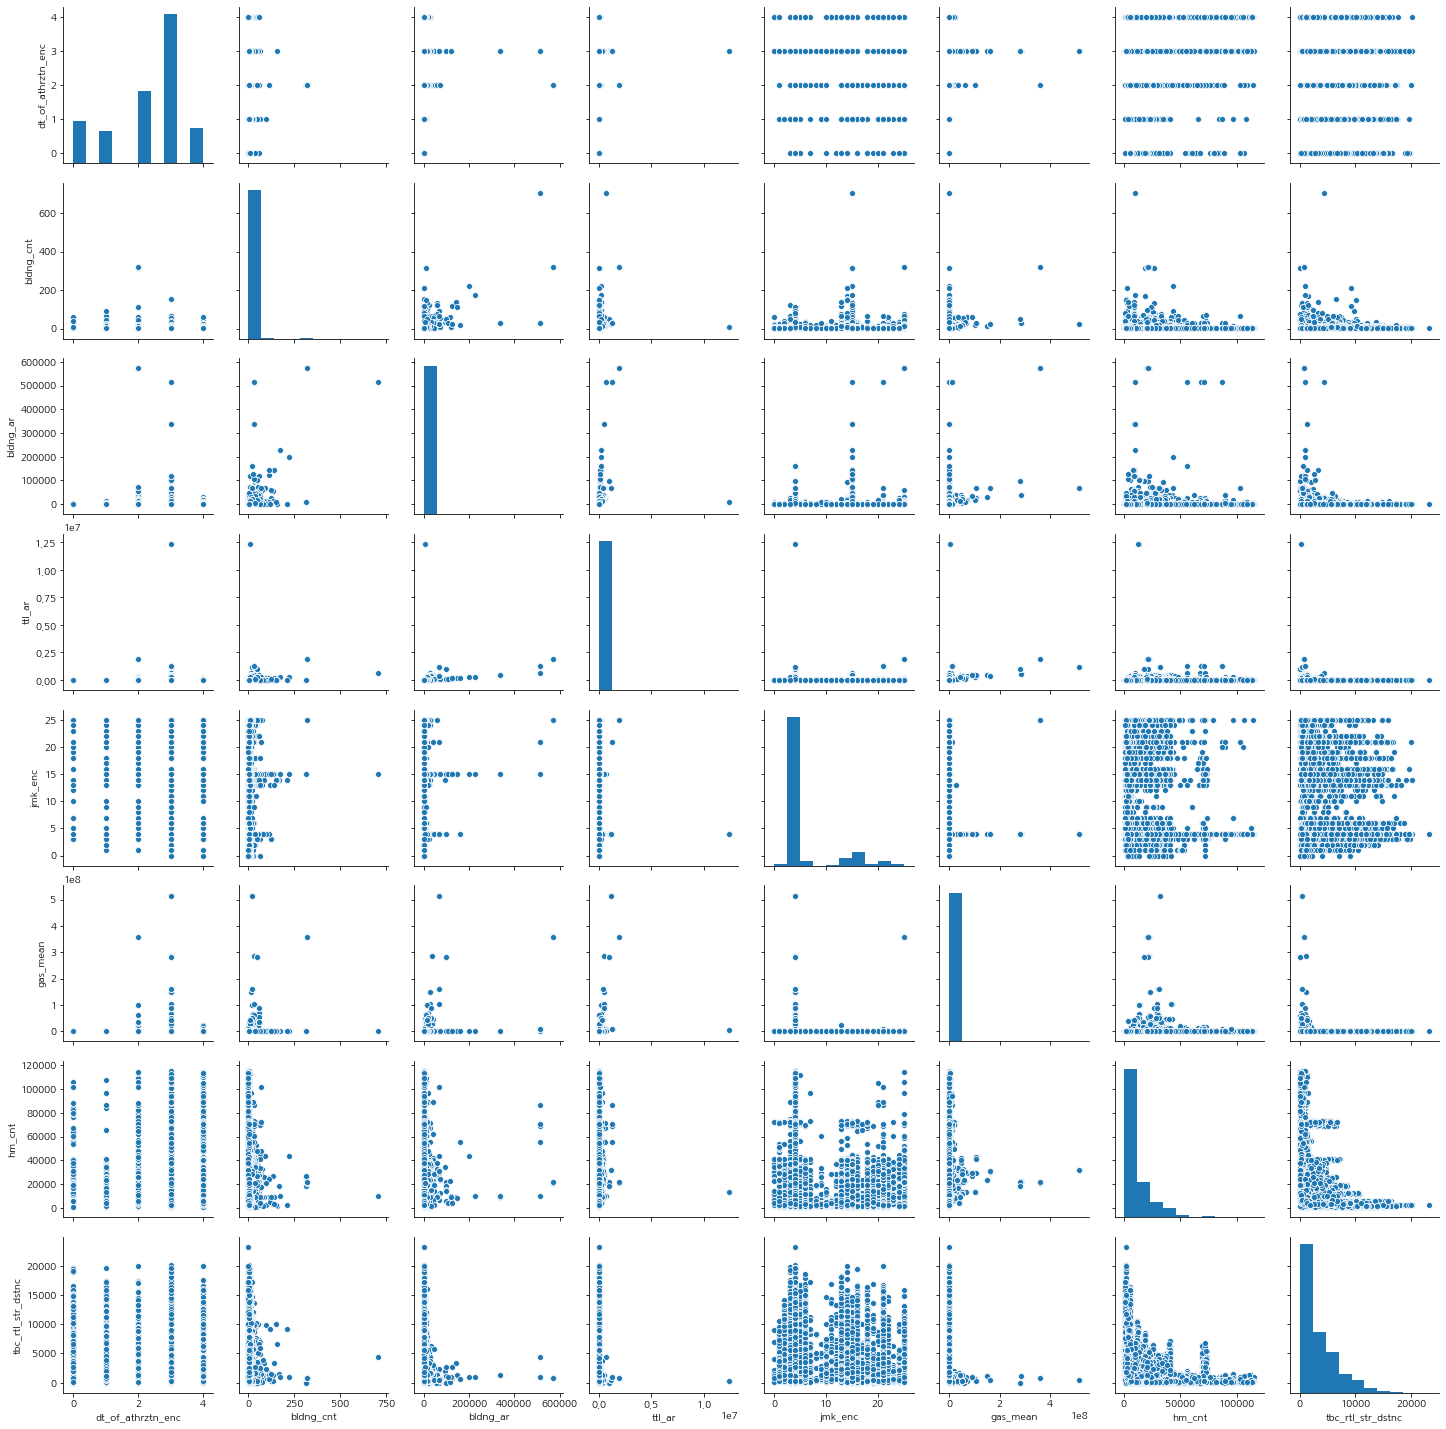

In [193]:
sns.pairplot(data[['dt_of_athrztn_enc','bldng_cnt','bldng_ar','ttl_ar','jmk_enc','gas_mean','hm_cnt','tbc_rtl_str_dstnc']])

- rgnl_ar_nm

In [23]:
data['rgnl_ar_nm'].value_counts()

계획관리지역       25552
제2종일반주거지역     9967
제1종일반주거지역     4438
자연녹지지역        3399
일반상업지역        3043
생산관리지역        2103
농림지역          2024
보전관리지역        1982
일반공업지역         902
제3종일반주거지역      827
제1종전용주거지역      751
자연환경보전지역       708
준주거지역          614
생산녹지지역         414
준공업지역          400
개발제한구역         252
보전녹지지역         157
제2종전용주거지역       72
근린상업지역          53
유통상업지역          28
중심상업지역          16
관리지역             4
용도미지정            2
Name: rgnl_ar_nm, dtype: int64

In [25]:
data.loc[data['rgnl_ar_nm'].str.contains('주거지역',na=False), 'rgnl_ar_nm_enc'] = 0 #주거지역
data.loc[data['rgnl_ar_nm'].str.contains('녹지지역',na=False), 'rgnl_ar_nm_enc'] = 1 #녹지지역
data.loc[data['rgnl_ar_nm'].str.contains('개발제한',na=False), 'rgnl_ar_nm_enc'] = 1 #녹지지역
data.loc[data['rgnl_ar_nm'].str.contains('보전',na=False),  'rgnl_ar_nm_enc'] =    1 #녹지지역
data.loc[data['rgnl_ar_nm'].str.contains('상업지역',na=False), 'rgnl_ar_nm_enc'] = 2 #상업지역
data.loc[data['rgnl_ar_nm'].str.contains('공업지역',na=False), 'rgnl_ar_nm_enc'] = 3 #공업지역
data.loc[data['rgnl_ar_nm'].str.contains('관리지역',na=False), 'rgnl_ar_nm_enc'] = 4 #관리지역
data.loc[data['rgnl_ar_nm'].str.contains('농림지역',na=False), 'rgnl_ar_nm_enc'] = 5 #녹지지역

In [26]:
data.loc[(data['rgnl_ar_nm_enc'].isnull()) & (data['bldng_us_clssfctn']=='상업용'),'rgnl_ar_nm_enc']=2
data.drop(index = data[(data['rgnl_ar_nm']=='용도미지정') & (data['rgnl_ar_nm_enc'].isnull())].index, inplace=True)

In [27]:
data['rgnl_ar_nm_enc'] = data['rgnl_ar_nm_enc'].astype('category')
data['jmk_enc'] = data['jmk_enc'].astype('category')
data['mlt_us_yn'] = data['mlt_us_yn'].astype('category')
data['dt_of_athrztn_enc'] = data['dt_of_athrztn_enc'].astype('category')

In [36]:
data.reset_index(drop=True, inplace=True)

In [34]:
# data_nn = data[(data['rgnl_ar_nm_enc'].notna()) & (data['bldng_ar_prc'].notna()) & (data['jmk_enc'].notna()) & (data['hm_cnt'].notna()) 
# & (data['bldng_ar'].notna()) & (data['ttl_ar'].notna()) & (data['ttl_grnd_flr'].notna()) & (data['mlt_us_yn'].notna())]

In [30]:
from sklearn import utils

In [35]:
data[['rgnl_ar_nm_enc','bldng_ar_prc','jmk_enc','hm_cnt','bldng_ar','ttl_ar','mlt_us_yn']].isnull().sum()

rgnl_ar_nm_enc    799
bldng_ar_prc        0
jmk_enc             0
hm_cnt              0
bldng_ar            0
ttl_ar              0
mlt_us_yn           0
dtype: int64

In [37]:
data.shape

(49517, 194)

In [134]:
rgnl_ar_knn = KNeighborsClassifier()

In [38]:
data['rgnl_ar_nm_enc'] = data['rgnl_ar_nm_enc'].astype('category')

In [39]:
rgnl_ar_imputer = IterativeImputer(max_iter=30)
rgnl_ar_impres = rgnl_ar_imputer.fit_transform(data[['rgnl_ar_nm_enc','bldng_ar_prc','jmk_enc','hm_cnt','bldng_ar','ttl_ar','mlt_us_yn']])
rgnl_ar_df = pd.DataFrame(rgnl_ar_impres, columns=['rgnl_ar_nm_enc','bldng_ar_prc','jmk_enc','hm_cnt','bldng_ar','ttl_ar','mlt_us_yn'])

In [44]:
data = pd.concat([data.drop(columns = 'rgnl_ar_nm_enc'), rgnl_ar_df['rgnl_ar_nm_enc']], axis=1)

- bldng_ar_prc

In [121]:
data['bldng_ar_prc'].sort_values(ascending=True).unique()[:10]

array([17537., 17775., 17841., 17966., 18830., 20526., 20736., 21829.,
       22786., 22803.])

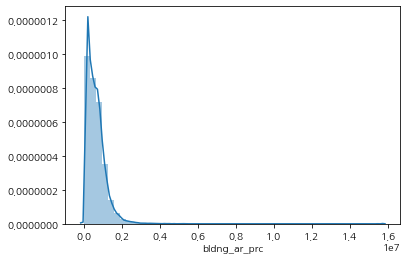

In [23]:
sns.distplot(data['bldng_ar_prc'].dropna())

In [22]:
bldng_ar_prc_imputer = IterativeImputer(min_value=17537 , max_value=5285714, max_iter=30 )

In [30]:
data[['bldng_ar_prc','dt_of_athrztn_enc','hm_cnt','bldng_ar','ttl_ar','ttl_grnd_flr','ttl_dwn_flr','fr_wthr_fclt_dstnc','mlt_us_yn','tbc_rtl_str_dstnc','ele_mean','rgnl_ar_nm_enc']].isnull().sum()

bldng_ar_prc          15362
dt_of_athrztn_enc     19570
hm_cnt                   65
bldng_ar                  0
ttl_ar                    0
ttl_grnd_flr           2542
ttl_dwn_flr            3320
fr_wthr_fclt_dstnc        0
mlt_us_yn                 0
tbc_rtl_str_dstnc         0
ele_mean                  0
rgnl_ar_nm_enc          799
dtype: int64

In [34]:
# bldng_ar_prc_impres = bldng_ar_prc_imputer.fit_transform(data[['bldng_ar_prc','dt_of_athrztn_enc','hm_cnt','bldng_ar','ttl_ar','ttl_grnd_flr','ttl_dwn_flr','fr_wthr_fclt_dstnc','mlt_us_yn','tbc_rtl_str_dstnc','ele_mean','rgnl_ar_nm_enc']])
# bldng_ar_prc_df = pd.DataFrame(bldng_ar_prc_impres, columns = ['bldng_ar_prc','dt_of_athrztn_enc','hm_cnt','bldng_ar','ttl_ar','ttl_grnd_flr','ttl_dwn_flr','fr_wthr_fclt_dstnc','mlt_us_yn','tbc_rtl_str_dstnc','ele_mean','rgnl_ar_nm_enc'])
data = pd.concat([data.drop(columns = ['bldng_ar_prc','hm_cnt']), bldng_ar_prc_df[['bldng_ar_prc','hm_cnt']]], axis=1)

In [139]:
# data_nn = data[(data['dt_of_athrztn'].notna()) & (data['bldng_ar'].notna() & (data['rgnl_ar_nm_enc'].notna()) & (data['tbc_rtl_str_dstnc'].notna()))]

In [118]:
# data[data['bldng_ar_prc'].notna()][['bldng_ar_prc','dt_of_athrztn','hm_cnt','bldng_ar','ttl_ar','ttl_grnd_flr','ttl_dwn_flr','fr_wthr_fclt_dstnc','mlt_us_yn','tbc_rtl_str_dstnc','ele_mean','lnd_us_sttn_nm']]

bldng_ar_prc  dt_of_athrztn   hm_cnt   bldng_ar       ttl_ar  \
1          122581.0            NaN   1791.0     46.290      46.2900   
2          618105.0         2000.0  17285.0    583.800    2516.7600   
3          719542.0         1936.0   7327.0     48.920      48.9200   
5          899087.0         2015.0  17278.0     96.660     149.0400   
7          233594.0         1994.0  17302.0     92.000      92.0400   
10         263117.0         1935.0  17199.0     98.960      98.9600   
11         918390.0            NaN  17199.0     44.970      44.9700   
12         684034.0         1992.0  17330.0   1046.400   12067.3800   
13         652729.0         1994.0  17282.0     44.220     129.5500   
14         751210.0         1930.0  17349.0     66.120      66.1200   
16        1129748.0         1980.0  17170.0     81.360      81.3600   
17         814516.0         1952.0  17170.0     49.580      49.5800   
19        1224408.0         1943.0  17281.0    238.360     284.7600   
21         443996.0            NaN  17150.0     89.250      89.2500   
22        1068405.0            NaN  17029.0    102.020     148.8200   
23         618105.0         2000.0  17029.0    583.800    2516.7600   
24         731808.0         1980.0  17029.0     73.480      73.4800   
26         994295.0         1971.0  17229.0     40.560      40.5600   
31         455941.0         2013.0  17143.0    253.320     253.3200   
36        1039631.0         2014.0  12343.0     37.560      36.8400   
40         499737.0            NaN  12678.0     76.040      76.0400   
41         819562.0         1988.0  23221.0    100.340     163.7200   
42        1834282.0         2004.0  12376.0     94.860      94.8600   
45         361533.0         1995.0  12503.0     82.980      82.9800   
47         864633.0            NaN  12729.0     39.670      39.6700   
...             ...            ...      ...        ...          ...   
59125      305677.0            NaN   9735.0     37.360      74.7200   
59130      547081.0            NaN   3017.0    110.830     116.5200   
59133      721334.0         2003.0  24684.0    140.060     244.6800   
59134      714253.0         2001.0   3526.0    484.840     559.2200   
59142      919679.0            NaN  19590.0  16096.990  239099.0500   
59144     1111604.0         2004.0  30931.0  19791.630  202843.7112   
59146     1111604.0         2004.0  31033.0  19791.630  202843.7112   
59147     1111604.0         2004.0  28367.0  19791.630  202843.7112   
59153      554194.0         2017.0  23304.0   1689.840    6791.3200   
59154      554194.0         2017.0  31620.0   1689.840    6791.3200   
59155      554194.0         2017.0  27945.0   1689.840    6791.3200   
59156      554194.0         2017.0  23950.0   1689.840    6791.3200   
59158     1028725.0         1997.0  15367.0    696.520    1482.0000   
59162      410426.0            NaN   6656.0    457.920     590.1600   
59164     1162602.0         2004.0   9275.0     97.900      97.9000   
59165     1433165.0         2008.0  10417.0  13378.000  275881.0200   
59166     1433165.0         2008.0   9568.0  13378.000  275881.0200   
59168      394857.0            NaN  11723.0     91.730     395.7400   
59169      972340.0         1979.0  12591.0     87.300     245.4600   
59173     1052827.0         1982.0  11020.0   1675.280    8376.4000   
59179      544706.0         2009.0  19358.0    248.330     242.7400   
59183      239521.0         1992.0   6225.0   1107.900    1100.5800   
59185      857474.0         1992.0   6788.0    241.420     457.2500   
59188      279219.0            NaN   3014.0    466.300     466.3000   
59195     1849455.0            NaN  21014.0   5593.711   54835.0382   

       ttl_grnd_flr  ttl_dwn_flr  fr_wthr_fclt_dstnc mlt_us_yn  \
1               1.0          0.0                 489         N   
2               5.0          0.0                 143         N   
3               1.0          0.0                1585         N   
5               2.0          0.0                 2

- hm_cnt

In [9]:
data_nn = data[data['hm_cnt'].notna()]
for small in data[data['hm_cnt'].isnull()]['emd_nm_small'].unique():
    hm_cnt_mean = data_nn[data_nn['emd_nm_small']==small]['hm_cnt'].mean()
    data.loc[(data['hm_cnt'].isnull()) & (data['emd_nm_small']==small), 'hm_cnt'] = hm_cnt_mean

In [38]:
data[data['hm_cnt'].isnull()][['emd_nm_small']]

emd_nm_small
1110           실안동
1327         마산합포구
1332         마산회원구
1388         마산회원구
1419         마산합포구
1521         마산회원구
1522         마산합포구
1524         마산회원구
1525         마산회원구
1527         마산회원구
1528         마산합포구
1529         마산합포구
1530         마산회원구
1531         마산합포구
1551         마산회원구
1552         마산합포구
1556         마산회원구
1557         마산합포구
1559         마산합포구
1563         마산회원구
2180         마산합포구
4023         마산회원구
7299         마산회원구
7405         마산합포구
7495         마산합포구
...            ...
52494        마산합포구
53001        마산합포구
53014        마산합포구
53031        마산회원구
54210          동금동
54214          동금동
54215          동금동
54250        마산회원구
54251        마산합포구
54902        마산합포구
54903        마산합포구
54904        마산합포구
55990        마산회원구
55992        마산합포구
55993        마산합포구
56534        마산합포구
57042          진해구
57061        마산회원구
57063        마산합포구
57588        마산회원구
57589        마산회원구
57611        마산합포구
58454        마산회원구
58624          nan
58816        마산합포구

[193 rows x 1 columns]

-  WEATHER
    - tmptr, hmdt, wnd_drctn, wnd_spd

In [9]:
print(data[data['season']==0]['wnd_drctn'].mean())
print(data[data['season']==1]['wnd_drctn'].mean())
print(data[data['season']==2]['wnd_drctn'].mean())
print(data[data['season']==3]['wnd_drctn'].mean())

197.71999358151476
177.0892567625224
201.03774442928605
225.1904922454484


In [10]:
print(data[data['season']==0]['wnd_spd'].mean())
print(data[data['season']==1]['wnd_spd'].mean())
print(data[data['season']==2]['wnd_spd'].mean())
print(data[data['season']==3]['wnd_spd'].mean())

1.7387286324786326
1.4921765156260876
1.2670753424657535
1.6335019378571898


In [10]:
data['fr_yn'] = data['fr_yn'].astype('category')
data['season'] = data['season'].astype('category')

In [11]:
weather_imputer = IterativeImputer(max_iter=20, random_state=0)
weather_data = data[['fr_yn','season','season_mean_differ','hmdt','wnd_drctn','wnd_spd','tmprtr']]
weather_imp_res = weather_imputer.fit_transform(weather_data)
weather_imp_df = pd.DataFrame(weather_imp_res, columns=weather_data.columns)
data = pd.concat([data.drop(columns=['fr_yn','season','season_mean_differ','hmdt','wnd_drctn','wnd_spd','tmprtr']) , weather_imp_df[['fr_yn','season','season_mean_differ','hmdt','wnd_drctn','wnd_spd','tmprtr']]], axis=1)

In [12]:
#wnd drctn 범주화(연속형 변수가 아님)
data = pp2nd_func.wnd_drctn_enc(data)

- BUILDING & LAND
    - jmk, multi_us_yn

In [13]:
jmk_le = LabelEncoder()
data['jmk_enc'] = jmk_le.fit_transform(data['jmk'])
data['mlt_us_yn_enc'] = data['mlt_us_yn'].apply(lambda x : 1 if x=='Y' else 0)

- ENERGY
    - ele, gas

In [14]:
ele_col = data.columns[data.columns.str.contains('ele')]
gas_col = data.columns[data.columns.str.contains('gas')]

In [15]:
data['gas_mean'] = np.nan
for idx, row in tqdm(data[data[gas_col].sum(1)!=0].iterrows()):
    use_period=0
    use_total=0
    for col in gas_col:
        if row[col]!=0:
            use_period+=1
            use_total+=row[col]
    use_mean = use_total / use_period
    data.loc[idx,'gas_mean'] = use_mean
data.loc[data[gas_col].sum(1)==0, 'gas_mean'] =0

2004it [00:02, 836.90it/s]


In [16]:
data['ele_mean'] = np.nan
for idx, row in tqdm(data[data[ele_col].sum(1)!=0].iterrows()):
    use_period=0
    use_total=0
    for col in ele_col:
        if row[col]!=0:
            use_period+=1
            use_total+=row[col]
    use_mean = use_total / use_period
    data.loc[idx,'ele_mean'] = use_mean
data.loc[data[ele_col].sum(1)==0, 'ele_mean'] =0

8614it [00:10, 832.63it/s]


- bldng archtctr

In [17]:
data = pp2nd_func.bldng_archtctr_enc(data)

In [18]:
data['bldng_archtctr'].value_counts()

벽돌구조      7377
목구조       6880
콘크리트구조    6709
철골구조      5825
블록구조      4087
기타조적구조     601
석구조         55
Name: bldng_archtctr, dtype: int64

In [46]:
bldng_archtctr_le = LabelEncoder()
data_nn = data[data['bldng_archtctr'].notna()]
data['bldng_archtctr_enc'] = np.nan
data_encoded = bldng_archtctr_le.fit_transform(data_nn['bldng_archtctr'])
data.loc[data_nn.index, 'bldng_archtctr_enc'] = data_encoded

In [ ]:
#### data[['bldng_ar','ttl_ar']].isnull().sum()

In [47]:
data['exp_bldng_flr'] = data['ttl_ar'] / data['bldng_ar']
data['exp_bldng_flr'] = data['exp_bldng_flr'].apply(lambda x : np.round(np.round(x,1)) if x!=np.nan else x )

In [25]:
data[['bldng_ar','ttl_ar','bldng_cnt','ttl_grnd_flr','ttl_dwn_flr']]

bldng_ar      ttl_ar  bldng_cnt  ttl_grnd_flr  ttl_dwn_flr
0         69.420     69.4200          3           1.0          0.0
1         46.290     46.2900          3           1.0          0.0
2        583.800   2516.7600          1           5.0          0.0
3         48.920     48.9200          2           1.0          0.0
4            NaN         NaN          2           NaN          NaN
5         96.660    149.0400          1           2.0          0.0
6         84.000     84.0000          1           1.0          0.0
7         92.000     92.0400          6           1.0          0.0
8        102.360    102.3600          8           1.0          0.0
9         66.130     66.1300          4           1.0          0.0
10        98.960     98.9600          2           1.0          0.0
11        44.970     44.9700          3           1.0          0.0
12      1046.400  12067.3800          3          17.0          1.0
13        44.220    129.5500          1           3.0          0.0
14        66.120     66.1200          4           1.0          0.0
15       551.840    819.6000          2           NaN          NaN
16        81.360     81.3600          4           1.0          0.0
17        49.580     49.5800          3           1.0          0.0
18       618.780    913.2200          6           4.0          0.0
19       238.360    284.7600          4           NaN          NaN
20       119.020    142.8600          2           3.0          0.0
21        89.250     89.2500          6           1.0          0.0
22       102.020    148.8200          1           NaN          NaN
23       583.800   2516.7600          1           5.0          0.0
24        73.480     73.4800          3           1.0          0.0
...          ...         ...        ...           ...          ...
59174    518.280    780.0600          4           4.0          0.0
59175    993.400   1488.4000          2           3.0          0.0
59176    175.630    175.6300          2           1.0          0.0
59177    163.500    640.5000          1           3.0          1.0
59178    206.720    224.7300          1           2.0          0.0
59179    248.330    242.7400          1           1.0          0.0
59180    126.320    126.3200          3           NaN          NaN
59181   1858.830   5427.2300          3           4.0          1.0
59182    422.920   1317.3200          2          10.0          0.0
59183   1107.900   1100.5800          7           1.0          0.0
59184   1020.840   1521.3300          7           4.0          0.0
59185    241.420    457.2500          4           5.0          0.0
59186    151.000    171.2000          1           2.0          0.0
59187  12144.580  12520.5300          9           5.0          0.0
59188    466.300    466.3000          6           3.0          0.0
59189    209.000    209.0000          2           1.0          0.0
59190   2211.100   2211.1000          6           4.0          0.0
59191    409.500    409.5000          6           1.0          0.0
59192    792.000    792.0000          2           2.0          0.0
59193    435.350    435.3500          2           2.0          0.0
59194    423.000    423.0000          2           NaN          NaN
59195   5593.711  54835.0382         35         171.0          0.0
59196   2436.820   2468.8000          2           4.0          0.0
59197    283.200    207.7100          2           2.0          0.0
59198    169.260    169.2600          3           1.0          0.0

[59199 rows x 5 columns]

In [48]:
data.loc[data["bldng_cnt"]<11, "bldng_cnt_enc"] = 0 
data.loc[(data["bldng_cnt"]>10)&(data["bldng_cnt"]<75), "bldng_cnt_enc"] = 1
data.loc[data["bldng_cnt"]>74, "bldng_cnt_enc"] = 2

In [49]:
data.loc[data["exp_bldng_flr"]<5, "exp_bldng_flr_enc"] = 0 
data.loc[(data["exp_bldng_flr"]>=5)&(data["bldng_cnt_enc"]<11), "exp_bldng_flr"] = 1
data.loc[data["exp_bldng_flr"]>=11, "exp_bldng_flr_enc"] = 2

- fr_mn_cnt

In [19]:
for big in data[data['fr_mn_cnt'].isnull()]['emd_nm_big'].unique():
    fr_mean = data[data['emd_nm_big']==big]['fr_mn_cnt'].mean()
    data.loc[(data['fr_mn_cnt'].isnull()) & (data['emd_nm_big']==big), 'fr_mn_cnt'] = fr_mean

- ttl_ar, bldng_ar, <b> lnd_ar

In [20]:
data.drop(columns='lnd_ar', inplace=True)

In [21]:
data.dropna(subset=['ttl_ar','bldng_ar'], inplace=True)

In [21]:
data[['ttl_ar','bldng_ar','hm_cnt','fr_mn_cnt','rgnl_ar_nm_enc','dt_of_athrztn_enc','jmk_enc','bldng_ar_prc']].isnull().sum()

KeyError: "['rgnl_ar_nm_enc'] not in index"

In [122]:
data['exp_bldng_ar_cnt'] = data['bldng_ar'] * data['bldng_cnt']

In [126]:
# data['exp_lnd_ar_cnt'] = data['lnd_ar'] / data['bldng_cnt']

- ttl_grnd_flr, ttl_dwn_flr, lnd_ar

In [210]:
data.isnull().sum().sort_values()[35:]

hmdt                                0
season_mean_differ                  0
mlt_us_yn_enc                       0
ttl_ar                              0
bldng_ar                            0
bldng_cnt                           0
fr_mn_cnt                          41
hm_cnt                            193
rd_sd_nm                         1491
rgnl_ar_nm                       1491
lnd_us_sttn_nm                   1776
exp_bldng_flr_enc                3120
ttl_grnd_flr                    10210
ttl_dwn_flr                     11005
exp_lnd_ar_cnt                  25569
lnd_ar                          25569
gas_engry_us_201810             27580
ele_engry_us_201810             27580
gas_engry_us_201811             27580
gas_engry_us_201502             27580
gas_engry_us_201812             27580
ele_engry_us_201812             27580
ele_engry_us_201502             27580
ele_engry_us_201809             27580
ele_engry_us_201811             27580
                                ...  
bldng_us    

In [205]:
data.drop(columns = 'lnd_us_sttn_nm', inplace=True)

In [214]:
data['ttl_grnd_flr'] = data['ttl_grnd_flr'].astype('category')
data['ttl_dwn_flr'] = data['ttl_dwn_flr'].astype('category')

In [227]:
flr_rf = RandomForestClassifier()

In [241]:
flr_imputer = IterativeImputer( max_iter= 30)
flr_impres = flr_imputer.fit_transform(data[['ttl_grnd_flr','ttl_dwn_flr','lnd_ar','bldng_ar','ttl_ar','dt_of_athrztn_enc', 'ele_mean','jmk_enc','rgnl_ar_nm_enc']])
flr_imp_df = pd.DataFrame(flr_impres, columns = ['ttl_grnd_flr','ttl_dwn_flr','lnd_ar','bldng_ar','ttl_ar','dt_of_athrztn_enc', 'ele_mean','jmk_enc','rgnl_ar_nm_enc'])
# pd.concat([data.drop(columns = ['ttl_grnd_flr','ttl_dwn_flr'])])

/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


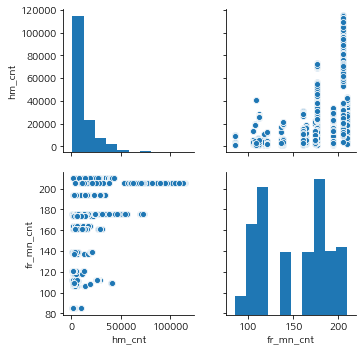

In [203]:
sns.pairplot(data[['hm_cnt','fr_mn_cnt']])